# Baseline Implementation: Standard Linear Regression with Mini-Batch Gradient Descent

## Overview

This notebook establishes our baseline implementation of linear regression using mini-batch gradient descent with a fixed learning rate. This serves as the reference point against which we'll compare our alternative training strategies.

## Objectives

1. Implement linear regression from scratch
2. Implement mini-batch gradient descent
3. Establish baseline performance metrics
4. Visualize training dynamics (loss vs iterations)
5. Understand convergence behavior

## Mathematical Foundation

For linear regression, we aim to minimize the Mean Squared Error (MSE):

$$\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2 = \frac{1}{n}\sum_{i=1}^{n}(y_i - \mathbf{w}^T\mathbf{x}_i - b)^2$$

Where:
- $\mathbf{w}$ is the weight vector
- $b$ is the bias term
- $\mathbf{x}_i$ is the feature vector for sample $i$
- $y_i$ is the true target value

The gradient with respect to weights:
$$\frac{\partial \text{MSE}}{\partial \mathbf{w}} = -\frac{2}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)\mathbf{x}_i$$

The gradient with respect to bias:
$$\frac{\partial \text{MSE}}{\partial b} = -\frac{2}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)$$

In mini-batch gradient descent, we update parameters using a subset of the data:
$$\mathbf{w} \leftarrow \mathbf{w} - \alpha \frac{\partial \text{MSE}}{\partial \mathbf{w}}$$
$$b \leftarrow b - \alpha \frac{\partial \text{MSE}}{\partial b}$$

Where $\alpha$ is the learning rate (fixed in our baseline).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## Data Loading and Preprocessing

We'll use the California Housing dataset, which contains housing information from the 1990 California census.

In [2]:
# Load the dataset
housing = fetch_california_housing()
X, y = housing.data, housing.target

print(f"Dataset shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature names: {housing.feature_names}")
print(f"\nTarget statistics:")
print(f"  Mean: {y.mean():.2f}")
print(f"  Std: {y.std():.2f}")
print(f"  Min: {y.min():.2f}")
print(f"  Max: {y.max():.2f}")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features (important for gradient descent)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTrain set size: {X_train_scaled.shape[0]}")
print(f"Test set size: {X_test_scaled.shape[0]}")

Dataset shape: (20640, 8)
Target shape: (20640,)

Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Target statistics:
  Mean: 2.07
  Std: 1.15
  Min: 0.15
  Max: 5.00

Train set size: 16512
Test set size: 4128


## Linear Regression Implementation

We'll implement linear regression from scratch to have full control over the training process.

In [3]:
class LinearRegression:
    """
    Linear Regression implementation with mini-batch gradient descent.
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, batch_size=32, random_state=42):
        """
        Parameters:
        -----------
        learning_rate : float
            Fixed learning rate for gradient descent
        n_iterations : int
            Number of training iterations
        batch_size : int
            Size of mini-batches
        random_state : int
            Random seed for reproducibility
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.loss_history = []
        
    def _initialize_parameters(self, n_features):
        """Initialize weights and bias."""
        np.random.seed(self.random_state)
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0.0
        
    def _compute_loss(self, X, y):
        """Compute MSE loss."""
        predictions = X @ self.weights + self.bias
        mse = np.mean((y - predictions) ** 2)
        return mse
    
    def _compute_gradients(self, X_batch, y_batch):
        """Compute gradients for a batch."""
        n_samples = X_batch.shape[0]
        predictions = X_batch @ self.weights + self.bias
        error = predictions - y_batch
        
        # Gradients
        dw = (2 / n_samples) * (X_batch.T @ error)
        db = (2 / n_samples) * np.sum(error)
        
        # Gradient clipping to prevent exploding gradients
        max_grad_norm = 10.0
        grad_norm = np.sqrt(np.sum(dw**2) + db**2)
        if grad_norm > max_grad_norm:
            scale = max_grad_norm / grad_norm
            dw *= scale
            db *= scale
        
        return dw, db
    
    def fit(self, X, y, verbose=True):
        """
        Train the model using mini-batch gradient descent.
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Training features
        y : array-like, shape (n_samples,)
            Training targets
        verbose : bool
            Whether to print progress
        """
        n_samples, n_features = X.shape
        self._initialize_parameters(n_features)
        
        # Training loop
        for iteration in range(self.n_iterations):
            # Shuffle data for each epoch
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            # Mini-batch gradient descent
            epoch_losses = []
            for i in range(0, n_samples, self.batch_size):
                # Get batch
                end_idx = min(i + self.batch_size, n_samples)
                X_batch = X_shuffled[i:end_idx]
                y_batch = y_shuffled[i:end_idx]
                
                # Compute gradients
                dw, db = self._compute_gradients(X_batch, y_batch)
                
                # Update parameters
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
                
                # Check for NaN/Inf to detect divergence
                if np.any(np.isnan(self.weights)) or np.isnan(self.bias) or \
                   np.any(np.isinf(self.weights)) or np.isinf(self.bias):
                    if verbose:
                        print(f"Warning: Divergence detected at iteration {iteration + 1}. Stopping early.")
                    # Fill remaining history with NaN to indicate divergence
                    while len(self.loss_history) < self.n_iterations:
                        self.loss_history.append(np.nan)
                    return
                
                # Compute batch loss
                batch_loss = self._compute_loss(X_batch, y_batch)
                epoch_losses.append(batch_loss)
            
            # Store average loss for this epoch
            avg_loss = np.mean(epoch_losses)
            self.loss_history.append(avg_loss)
            
            if verbose and (iteration + 1) % 100 == 0:
                print(f"Iteration {iteration + 1}/{self.n_iterations}, Loss: {avg_loss:.4f}")
    
    def predict(self, X):
        """Make predictions."""
        return X @ self.weights + self.bias
    
    def get_parameters(self):
        """Return model parameters."""
        return self.weights.copy(), self.bias

print("Linear Regression class defined!")

Linear Regression class defined!


## Baseline Training

Let's train our baseline model and observe the training dynamics.

In [4]:
# Train baseline model
baseline_model = LinearRegression(
    learning_rate=0.01,
    n_iterations=1000,
    batch_size=32,
    random_state=42
)

print("Training baseline model...")
baseline_model.fit(X_train_scaled, y_train, verbose=True)

# Evaluate on test set
y_pred = baseline_model.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred)

print(f"\n=== Baseline Model Performance ===")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")

Training baseline model...
Iteration 100/1000, Loss: 0.5125
Iteration 200/1000, Loss: 0.5138
Iteration 300/1000, Loss: 0.5130
Iteration 400/1000, Loss: 0.5147
Iteration 500/1000, Loss: 0.5150
Iteration 600/1000, Loss: 0.5143
Iteration 700/1000, Loss: 0.5167
Iteration 800/1000, Loss: 0.5136
Iteration 900/1000, Loss: 0.5180
Iteration 1000/1000, Loss: 0.5135

=== Baseline Model Performance ===
Test MSE: 0.5691
Test RMSE: 0.7544
Test R²: 0.5657


## Visualization: Training Dynamics

Let's visualize how the loss decreases over iterations. This will serve as our baseline for comparison.

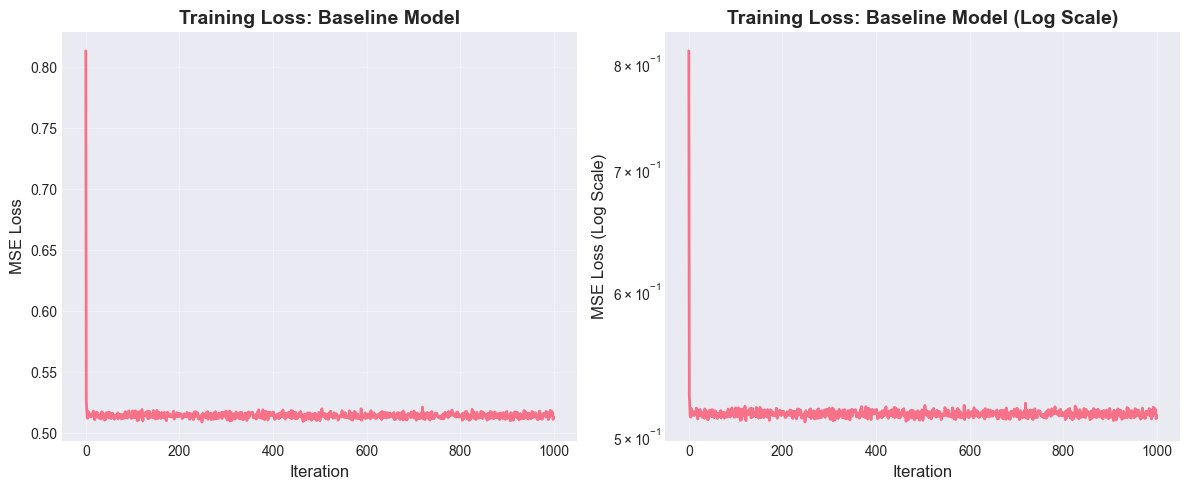

=== Convergence Analysis ===
Initial Loss: 0.8134
Final Loss: 0.5135
Loss Reduction: 36.87%
Convergence Rate (last 100 iterations): -0.000023


In [5]:
# Plot training loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(baseline_model.loss_history, linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Training Loss: Baseline Model', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(baseline_model.loss_history, linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('MSE Loss (Log Scale)', fontsize=12)
plt.title('Training Loss: Baseline Model (Log Scale)', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print convergence statistics
print("=== Convergence Analysis ===")
print(f"Initial Loss: {baseline_model.loss_history[0]:.4f}")
print(f"Final Loss: {baseline_model.loss_history[-1]:.4f}")
print(f"Loss Reduction: {((baseline_model.loss_history[0] - baseline_model.loss_history[-1]) / baseline_model.loss_history[0] * 100):.2f}%")
print(f"Convergence Rate (last 100 iterations): {np.mean(np.diff(baseline_model.loss_history[-100:])):.6f}")

## Learning Rate Sensitivity Analysis

Before moving to alternative strategies, let's understand how sensitive our baseline is to learning rate. This will help us contextualize the adaptive learning rate experiments.

LR=0.001: Test RMSE=0.7456
LR=0.010: Test RMSE=0.7544
LR=0.100: Test RMSE=0.8314
LR=0.500: Test RMSE=1.0714


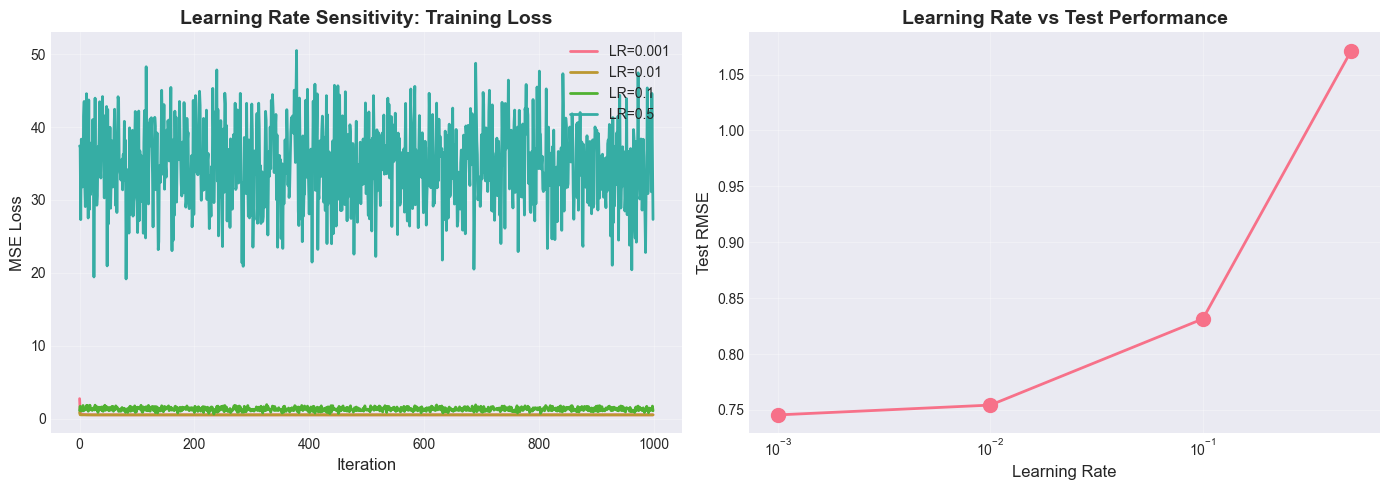


=== Baseline Established ===
We'll use this as our reference point for comparing alternative training strategies.


In [6]:
# Test different learning rates
learning_rates = [0.001, 0.01, 0.1, 0.5]
lr_results = {}

for lr in learning_rates:
    model = LinearRegression(
        learning_rate=lr,
        n_iterations=1000,
        batch_size=32,
        random_state=42
    )
    model.fit(X_train_scaled, y_train, verbose=False)
    
    y_pred = model.predict(X_test_scaled)
    
    # Check for NaN predictions (divergence)
    if np.any(np.isnan(y_pred)) or np.any(np.isinf(y_pred)):
        print(f"LR={lr:.3f}: Diverged (NaN/Inf predictions)")
        lr_results[lr] = {
            'loss_history': model.loss_history.copy(),
            'test_rmse': np.nan
        }
    else:
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        lr_results[lr] = {
            'loss_history': model.loss_history.copy(),
            'test_rmse': test_rmse
        }
        print(f"LR={lr:.3f}: Test RMSE={test_rmse:.4f}")

# Visualize learning rate comparison
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for lr, results in lr_results.items():
    # Filter out NaN values for plotting
    loss_history = np.array(results['loss_history'])
    valid_mask = ~np.isnan(loss_history)
    if np.any(valid_mask):
        plt.plot(np.where(valid_mask)[0], loss_history[valid_mask], label=f'LR={lr}', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Learning Rate Sensitivity: Training Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
lrs = list(lr_results.keys())
rmses = [lr_results[lr]['test_rmse'] for lr in lrs]
# Filter out NaN values for plotting
valid_data = [(lr, rmse) for lr, rmse in zip(lrs, rmses) if not np.isnan(rmse)]
if valid_data:
    valid_lrs, valid_rmses = zip(*valid_data)
    plt.plot(valid_lrs, valid_rmses, marker='o', linewidth=2, markersize=10)
plt.xlabel('Learning Rate', fontsize=12)
plt.ylabel('Test RMSE', fontsize=12)
plt.title('Learning Rate vs Test Performance', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store baseline results for comparison
baseline_results = {
    'model': baseline_model,
    'test_rmse': test_rmse,
    'test_r2': test_r2,
    'loss_history': baseline_model.loss_history.copy(),
    'learning_rate': 0.01
}

print("\n=== Baseline Established ===")
print("We'll use this as our reference point for comparing alternative training strategies.")

In [7]:
# Save results using pickle
import pickle
import os

results_dir = os.path.join(os.path.dirname(os.getcwd()), 'results')
os.makedirs(results_dir, exist_ok=True)

# Update baseline_results to include all necessary info
baseline_results['method'] = 'Baseline (Fixed LR)'
baseline_results['test_mse'] = test_mse
baseline_results['final_loss'] = baseline_model.loss_history[-1]
baseline_results['initial_loss'] = baseline_model.loss_history[0]
# Remove model object (not serializable)
baseline_results.pop('model', None)

with open(os.path.join(results_dir, '01_baseline_results.pkl'), 'wb') as f:
    pickle.dump(baseline_results, f)

print(f"\nResults saved to: {os.path.join(results_dir, '01_baseline_results.pkl')}")


Results saved to: d:\project\ML\project6_alternative_training_strategies\results\01_baseline_results.pkl
